# Cell Regionalization

In geospatial analysis, regions are like clusters, where the members of the region are similar to each other in their attriburtes, but different from the members of other regions. The difference of regions and clusters is that regions are always spatially contiguous, meaning that they are connected to each other. In other words, regions are clusters with a spatial constraint. Regionalization is the process of finding regions in a spatial dataset.

> *A regionalization is a special kind of clustering where the objective is to group observations which are similar in their statistical attributes, but also in their spatial location. In this sense, regionalization embeds the same logic as standard clustering techniques, but also it applies a series of geographical constraints. Often, these constraints relate to connectivity: two candidates can only be grouped together in the same region if there exists a path from one member to another member that never leaves the region.* - [Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf](https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html#geodemographic-clusters-in-san-diego-census-tracts)

In this notebook, instead of looking at the immune cells like in the previous examples, we'll be taking a look at neoplastic cells inside the tumor areas of a cervical pre-cancerous biopsy. Especially, we will explore the nuclei morphology characteristics and diversities of the cell neighborhoods inside the lesion.

This notebook is adjusted and adapted version of [this notebook](https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html#geodemographic-clusters-in-san-diego-census-tracts) from the great geographic science cookbook by Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf

<Axes: >

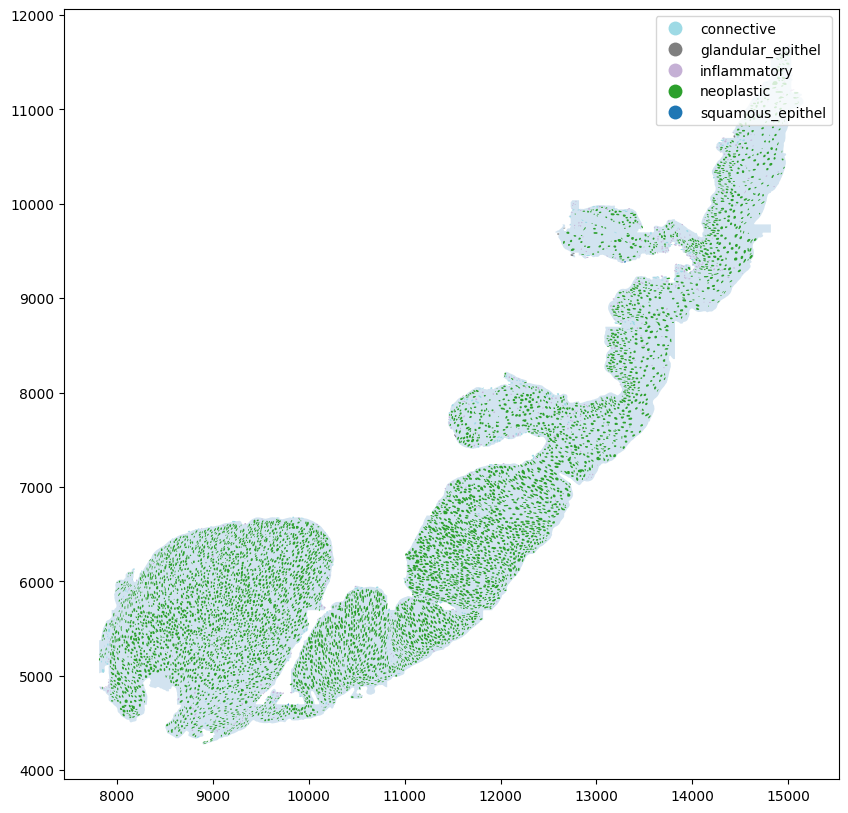

In [1]:
import numpy as np
from pathlib import Path
from cellseg_gsontools.utils import read_gdf

import warnings
warnings.filterwarnings("ignore")

tissue_path = Path("/path/to/tissues.geojson")
nuc_path = Path("/path/to/nuclei.geojson")

tissues = read_gdf(tissue_path)
cells = read_gdf(nuc_path)

tumor = tissues[tissues["class_name"] == "area_cin"]

# set the crs to avoid annoying warnings
tumor.set_crs(4328, inplace=True, allow_override=True)
tumor = tumor.loc[tumor.area > 1e6] # drop small tumor areas

# get the cells that intersect the tumor
_, cell_inds = cells.sindex.query(tumor.geometry, predicate="intersects")
neoplastic = cells.iloc[np.unique(cell_inds)]
neoplastic = neoplastic[["geometry", "class_name"]]
neoplastic.reset_index(drop=True, inplace=True)
neoplastic.set_crs(4328, inplace=True, allow_override=True)

# plot the tumor and neoplastic cells
ax = tumor.plot(
    column="class_name",
    figsize=(10, 10),
    alpha=0.2,
    aspect=None
)
neoplastic.plot(
    ax=ax,
    column="class_name",
    aspect=None,
    legend=True,
    cmap="tab20_r"
)

## Morphological Features

Let's now compute all the morphological features `cellseg_gsontools` has to offer for every neoplastic cell.

In [2]:
from cellseg_gsontools.geometry import shape_metric

metrics = [
    "area",
    "compactness",
    "circularity",
    "convexity",
    "solidity",
    "elongation",
    "eccentricity",
    "fractal_dimension",
    "sphericity",
    "shape_index",
    "rectangularity",
    "squareness",
    "equivalent_rectangular_index",
]

neoplastic = shape_metric(neoplastic, metrics)
neoplastic.head(4)

,geometry,class_name,area,compactness,circularity,convexity,solidity,elongation,eccentricity,fractal_dimension,sphericity,shape_index,rectangularity,squareness,equivalent_rectangular_index
0,"POLYGON ((7854.00000 5031.01000, 7850.01000 50...",connective,795.21535,0.881246,0.881246,1.000000,1.000000,0.600050,0.799962,0.799962,0.530560,0.767377,0.829109,1.122037,0.757876
1,"POLYGON ((7848.00000 4860.01000, 7845.01000 48...",neoplastic,168.86025,0.663535,0.663535,1.000000,1.000000,0.332777,0.943005,0.943005,0.244941,0.598589,0.882420,0.844839,0.831070
2,"POLYGON ((7864.00000 4862.01000, 7862.01000 48...",inflammatory,156.03025,0.794335,0.794335,1.000000,1.000000,0.473130,0.880993,0.880993,0.407591,0.718114,0.915453,1.011379,0.850077
3,"POLYGON ((7890.00000 4876.01000, 7886.55000 48...",inflammatory,133.51025,0.890833,0.893567,0.998469,0.984696,0.922958,0.384900,0.384900,0.633114,0.825456,0.858585,1.134244,0.805529


## Neighborhood Features

Next, we'll compute the mean of the morphologic features for each cell neighborhood. To get the neighborhood features, we need to compute the spatial weights first.

In [3]:
from cellseg_gsontools.graphs import fit_graph
from cellseg_gsontools.character import local_character
from cellseg_gsontools.utils import set_uid

neoplastic = set_uid(neoplastic)
w = fit_graph(neoplastic, "delaunay", thresh=100, id_col="uid")

neoplastic = local_character(
    neoplastic,
    w,
    val_col=metrics,
    reductions=["mean"]
)

neoplastic.head(4)

,geometry,class_name,area,compactness,circularity,convexity,solidity,elongation,eccentricity,fractal_dimension,...,convexity_nhood_mean,solidity_nhood_mean,elongation_nhood_mean,eccentricity_nhood_mean,fractal_dimension_nhood_mean,sphericity_nhood_mean,shape_index_nhood_mean,rectangularity_nhood_mean,squareness_nhood_mean,equivalent_rectangular_index_nhood_mean
uid,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON ((7854.00000 5031.01000, 7850.01000 50...",connective,795.21535,0.881246,0.881246,1.000000,1.000000,0.600050,0.799962,0.799962,...,0.997083,0.975846,0.646028,0.759367,0.759367,0.527334,0.766463,0.784753,1.066610,0.740143
1,"POLYGON ((7848.00000 4860.01000, 7845.01000 48...",neoplastic,168.86025,0.663535,0.663535,1.000000,1.000000,0.332777,0.943005,0.943005,...,0.998897,0.990085,0.526516,0.806540,0.806540,0.399299,0.693164,0.845752,0.969814,0.800913
2,"POLYGON ((7864.00000 4862.01000, 7862.01000 48...",inflammatory,156.03025,0.794335,0.794335,1.000000,1.000000,0.473130,0.880993,0.880993,...,0.998576,0.987273,0.564956,0.764074,0.764074,0.434008,0.698289,0.839377,0.972812,0.797451
3,"POLYGON ((7890.00000 4876.01000, 7886.55000 48...",inflammatory,133.51025,0.890833,0.893567,0.998469,0.984696,0.922958,0.384900,0.384900,...,0.999186,0.992727,0.601116,0.751994,0.751994,0.446453,0.731006,0.844712,1.021302,0.795565


## Neighborhood Diversity Features

Let's now compute the shannon diversity for each morphological metric to get a metric for the morphological diversities of the cell neighborhoods inside the lesion.

In [4]:
from cellseg_gsontools.diversity import local_diversity

neoplastic = local_diversity(
    neoplastic,
    w,
    val_col=metrics,
    metrics=["shannon_index"],
    scheme="FisherJenks" # binning scheme for real values
)

neoplastic.head(4)

,geometry,class_name,area,compactness,circularity,convexity,solidity,elongation,eccentricity,fractal_dimension,...,convexity_shannon_index,solidity_shannon_index,elongation_shannon_index,eccentricity_shannon_index,fractal_dimension_shannon_index,sphericity_shannon_index,shape_index_shannon_index,rectangularity_shannon_index,squareness_shannon_index,equivalent_rectangular_index_shannon_index
uid,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON ((7854.00000 5031.01000, 7850.01000 50...",connective,795.21535,0.881246,0.881246,1.000000,1.000000,0.600050,0.799962,0.799962,...,0.636514,0.636514,0.636514,0.636514,0.636514,0.636514,0.000000,0.636514,1.098612,0.636514
1,"POLYGON ((7848.00000 4860.01000, 7845.01000 48...",neoplastic,168.86025,0.663535,0.663535,1.000000,1.000000,0.332777,0.943005,0.943005,...,0.636514,0.867563,1.011404,0.450561,0.450561,1.329661,1.011404,0.867563,1.242453,1.011404
2,"POLYGON ((7864.00000 4862.01000, 7862.01000 48...",inflammatory,156.03025,0.794335,0.794335,1.000000,1.000000,0.473130,0.880993,0.880993,...,0.693147,1.039721,1.039721,0.562335,0.562335,1.386294,1.039721,0.562335,1.039721,1.039721
3,"POLYGON ((7890.00000 4876.01000, 7886.55000 48...",inflammatory,133.51025,0.890833,0.893567,0.998469,0.984696,0.922958,0.384900,0.384900,...,0.598270,0.796312,1.475076,1.153742,1.153742,1.351784,1.351784,0.955700,1.351784,0.955700


## Neighborhood Distances

Among the neighborhood characters and diversities, we'll also compute the mean neighborhood distances.

In [5]:
from cellseg_gsontools.character import local_distances

neoplastic = local_distances(
    neoplastic,
    w,
    reductions=["mean"],
)

neoplastic.head(4)

,geometry,class_name,area,compactness,circularity,convexity,solidity,elongation,eccentricity,fractal_dimension,...,solidity_shannon_index,elongation_shannon_index,eccentricity_shannon_index,fractal_dimension_shannon_index,sphericity_shannon_index,shape_index_shannon_index,rectangularity_shannon_index,squareness_shannon_index,equivalent_rectangular_index_shannon_index,nhood_dists_mean
uid,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON ((7854.00000 5031.01000, 7850.01000 50...",connective,795.21535,0.881246,0.881246,1.000000,1.000000,0.600050,0.799962,0.799962,...,0.636514,0.636514,0.636514,0.636514,0.636514,0.000000,0.636514,1.098612,0.636514,58.482000
1,"POLYGON ((7848.00000 4860.01000, 7845.01000 48...",neoplastic,168.86025,0.663535,0.663535,1.000000,1.000000,0.332777,0.943005,0.943005,...,0.867563,1.011404,0.450561,0.450561,1.329661,1.011404,0.867563,1.242453,1.011404,37.818833
2,"POLYGON ((7864.00000 4862.01000, 7862.01000 48...",inflammatory,156.03025,0.794335,0.794335,1.000000,1.000000,0.473130,0.880993,0.880993,...,1.039721,1.039721,0.562335,0.562335,1.386294,1.039721,0.562335,1.039721,1.039721,23.722000
3,"POLYGON ((7890.00000 4876.01000, 7886.55000 48...",inflammatory,133.51025,0.890833,0.893567,0.998469,0.984696,0.922958,0.384900,0.384900,...,0.796312,1.475076,1.153742,1.153742,1.351784,1.351784,0.955700,1.351784,0.955700,32.163000


Let's visualize the connectivity graph just for fun!

<Axes: >

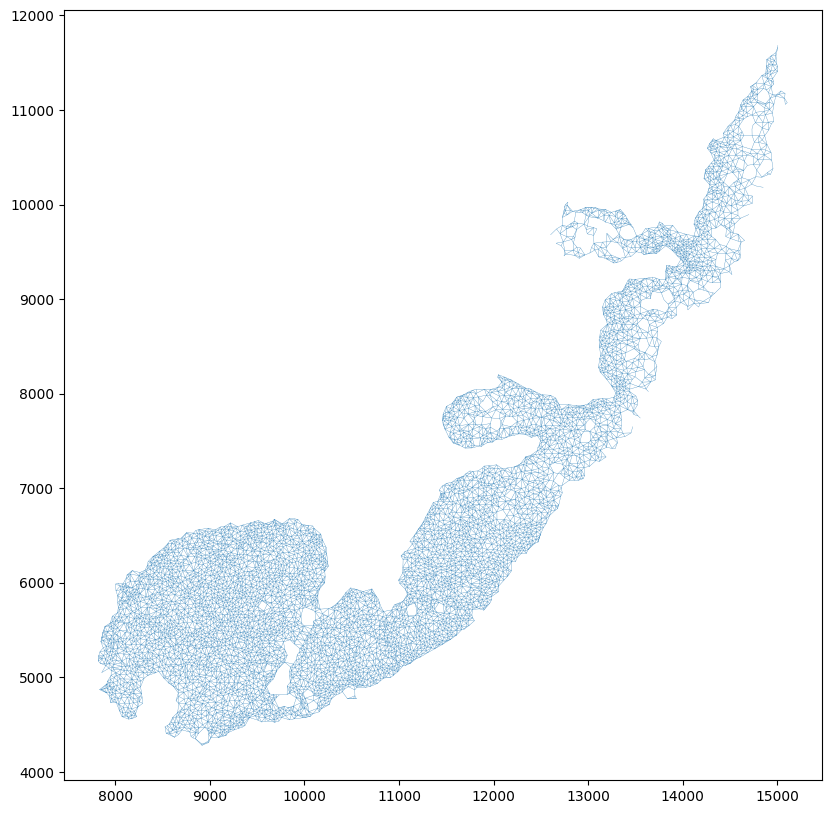

In [6]:
from cellseg_gsontools.links import weights2gdf

w_gdf = weights2gdf(neoplastic, w)
w_gdf.plot(linewidth=0.2, figsize=(10, 10))

We can clearly see that the tumor has some sparser and denser areas. That's why it would be intuitive that atleast the mean distance of the neighborhood could affect the clustering at some level.

## Compute Moran's I for the Features

We want to measure whether these variables contain spatial structure. For this we'll compute the Moran's I for each of the features. If the Moran's I value is close to 1, it means that the feature is highly spatially autocorrelated. If the Moran's I value is close to -1, it means that the feature is highly spatially dispersed. If the Moran's I value is close to 0, it means that the feature is randomly distributed in space.

In [7]:
# !pip install esda

In [8]:
import esda
import pandas as pd

np.random.seed(420)

clust_vars = neoplastic.loc[:, ~neoplastic.columns.isin(["uid", "geometry", "class_name"])]

# Calculate Moran's I for each variable
mi_results = [
    esda.Moran(clust_vars[variable], w) for variable in clust_vars.columns
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(clust_vars.columns, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")

table

,Moran's I,P-value
Variable,,
area,0.188537,0.001
compactness,0.297176,0.001
circularity,0.305584,0.001
convexity,0.037879,0.002
solidity,0.031049,0.001
elongation,0.315186,0.001
eccentricity,0.176556,0.001
fractal_dimension,0.176556,0.001
sphericity,0.300186,0.001


From the above table we can see that most of the morphological features are not too positively autocorrelated, however, all the features related to the neighborhoods (except the mean distances between cells) seem to have high positive autocorrelation. This means that the neighborhood features inside the lesion are not randomly distributed in space, but rather contain some sort of spatial structure. 

Note: being positively autocorrelated does not say much about how attributes co-vary over space and thus we don't know if some attributes cluster together based on the spatial autocorrelation. 

## Hierarchical Agglomerative Clustering of the Features

Next, we'll cluster the cells based on their morphological and neighborhood features with hierarchical clustering. For now, we don't spatially constrain the algorithm to see whether simple clustering of the cell attributes show visual spatial structure. We'll use the silhouette score to detect the best number of clusters before doing the final clustering. We'll pick only a subset of the features we computed since so many of them are correlated and bring little value in separating clusters from each other. 

Note: We won't scale the variables, although, some of the features like the area and mean nhood distances are on a different scale than the other features. We do this because we want these features to have a higher weight in the clustering.

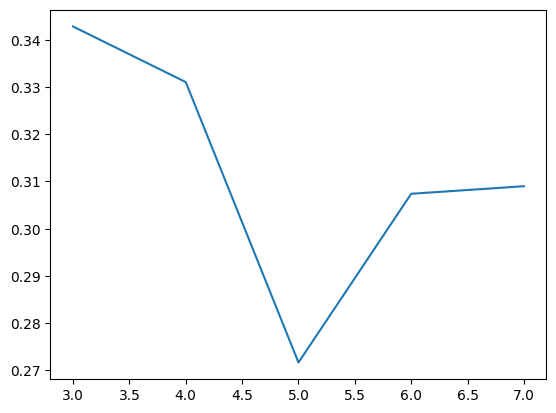

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import robust_scale, minmax_scale

from sklearn import set_config
set_config(transform_output = "pandas") # return pandas dataframes

# helper function to calculate Silhouette score for a range of clusters
def get_silhouette(range: range, clust_vars, connectivity=None):
    sil_score = []
    for i in range:
        # cluster using hierarchical clustering
        aggl = AgglomerativeClustering(n_clusters=i, linkage="ward", connectivity=connectivity)
        aggl.fit(clust_vars)
        labels = aggl.labels_
        
        # calculate Silhouette score
        score = silhouette_score(
            clust_vars,
            labels,
            metric="euclidean",
            sample_size=1000,
            random_state=200
        )
        sil_score.append(score)

    return sil_score

# subset of features to use for clustering
vars = [
    "area",
    "sphericity",
    "eccentricity",
    "elongation",
    "compactness",
    "area_nhood_mean",
    "sphericity_nhood_mean",
    "elongation_nhood_mean",
    "compactness_nhood_mean",
    "eccentricity_nhood_mean",
    "sphericity_shannon_index",
    "elongation_shannon_index",
    "compactness_shannon_index",
    "eccentricity_shannon_index",
    "area_shannon_index",
    "nhood_dists_mean"
]

clust_vars = neoplastic[vars]

# Uncomment this if you want to scale the variables before clustering
# cols = clust_vars.columns
# big_feats = ["area", "area_nhood_mean", "nhood_dists_mean"]
# clust_vars[big_feats] = minmax_scale(clust_vars[big_feats])
# clust_vars.columns = cols

sil_score = get_silhouette(range(3, 8), clust_vars)
plt.plot(range(3, 8), sil_score)

The best number of clusters is the max silhouette score. This means that the best number of clusters here is two. This probably indicates that the clusters are not well separable from each other based on just the cell features without spatial constraints. Let's now cluster the cells. Instead of using just two clusters, we'll use three clusters because 2 is just too little...

<Axes: >

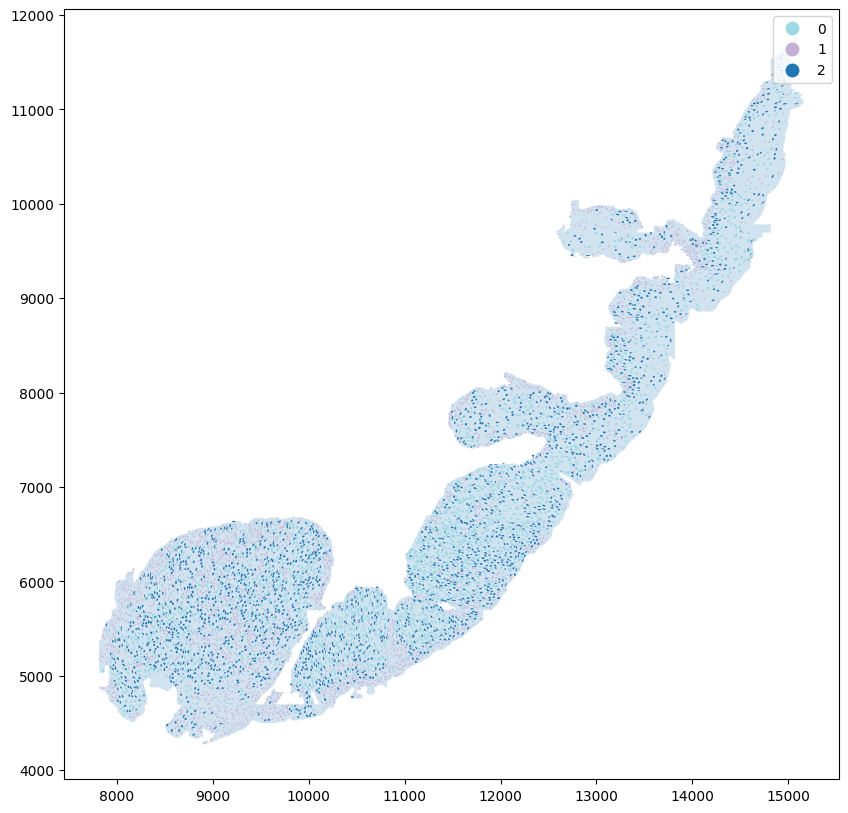

In [10]:
# cluster using hierarchical clustering
n_clust = range(3, 8)[np.argmax(sil_score)]
aggl = AgglomerativeClustering(n_clusters=n_clust, linkage="ward")
aggl.fit(clust_vars)
neoplastic["labels"] = aggl.labels_

# plot the tumor and neoplastic cells
ax = tumor.plot(
    column="class_name",
    figsize=(10, 10),
    alpha=0.2,
    aspect=None
)
neoplastic.plot(
    ax=ax,
    column="labels",
    aspect=None,
    legend=True,
    categorical=True,
    cmap="tab20_r"
)

From the plot above we see that the clusters that there is little to none spatial structure in the clusters. The clusters are not spatially contiguous and the cells are scattered all over the lesion. This is probably because the clustering algorithm is not spatially constrained.

In [11]:
tt = neoplastic[["labels"] + clust_vars.columns.tolist()].groupby("labels").mean().T.round(3)
tt

labels,0,1,2
area,615.589,196.781,351.902
sphericity,0.502,0.452,0.495
eccentricity,0.752,0.746,0.747
elongation,0.708,0.686,0.699
compactness,0.808,0.791,0.819
area_nhood_mean,447.310,265.057,389.967
sphericity_nhood_mean,0.492,0.461,0.494
elongation_nhood_mean,0.701,0.686,0.705
compactness_nhood_mean,0.811,0.794,0.815
eccentricity_nhood_mean,0.750,0.750,0.741


## Regionalization

Next, we'll apply the same hierarchical clustering algorithm, but this time we will spatially constrain the algorithm. The aim is to find spatially contiguous clusters that have similar morphological and neighborhood feature values.  

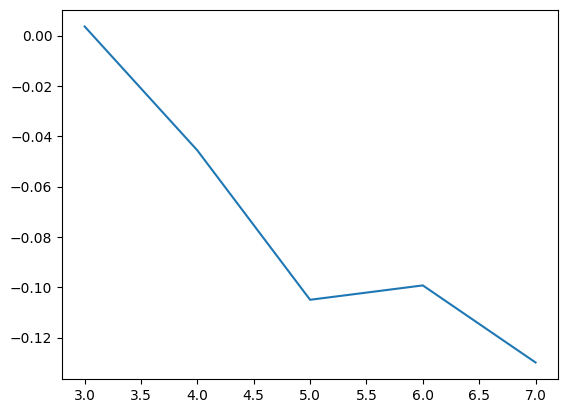

In [12]:
sil_score = get_silhouette(range(3, 8), clust_vars, connectivity=w.sparse)

plt.plot(range(3, 8), sil_score)

<Axes: >

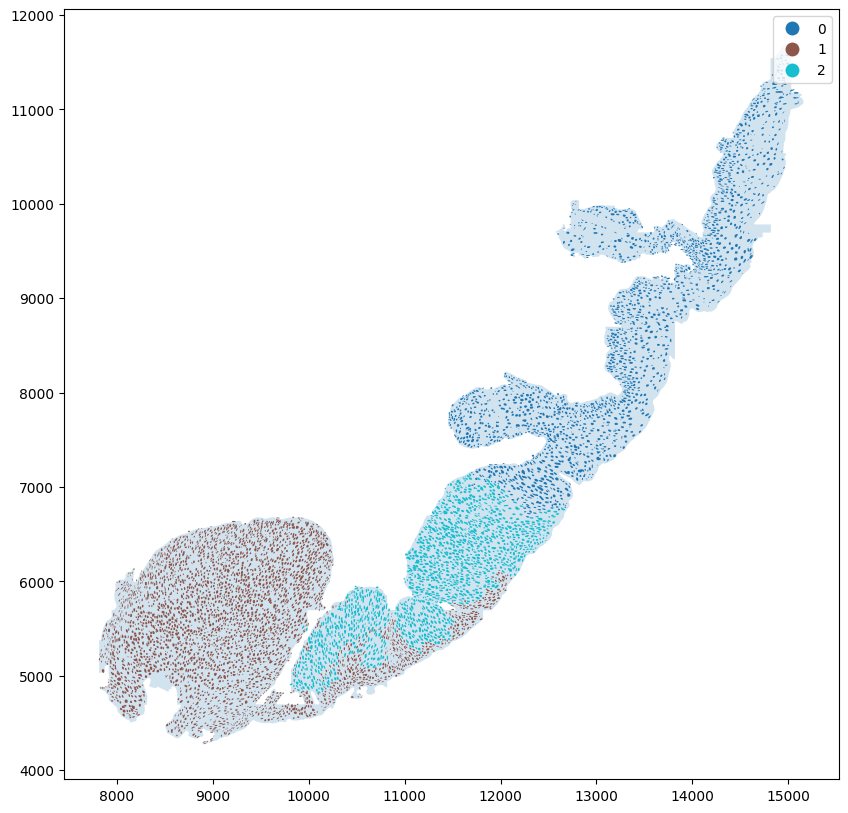

In [13]:
aggl = AgglomerativeClustering(
    linkage="ward",
    connectivity=w.sparse,
    n_clusters=range(3, 8)[np.argmax(sil_score)]
)

aggl.fit(clust_vars)
neoplastic["labels_constrained"] = aggl.labels_

# plot the tumor and neoplastic cells
ax = tumor.plot(
    column="class_name",
    figsize=(10, 10),
    alpha=0.2,
    aspect=None
)
neoplastic.plot(
    ax=ax,
    column="labels_constrained",
    aspect=None,
    legend=True,
    categorical=True,
)

As you can see from the plot, once we apply a spatial constraint to the clustering algorithm, the clusters are more spatially contiguous and we get clear spatial structure in the clusters. The clusters differ in their morphological and neighborhood features as well as in their spatial location.

Let's plot the differences between the clusters for each feature.

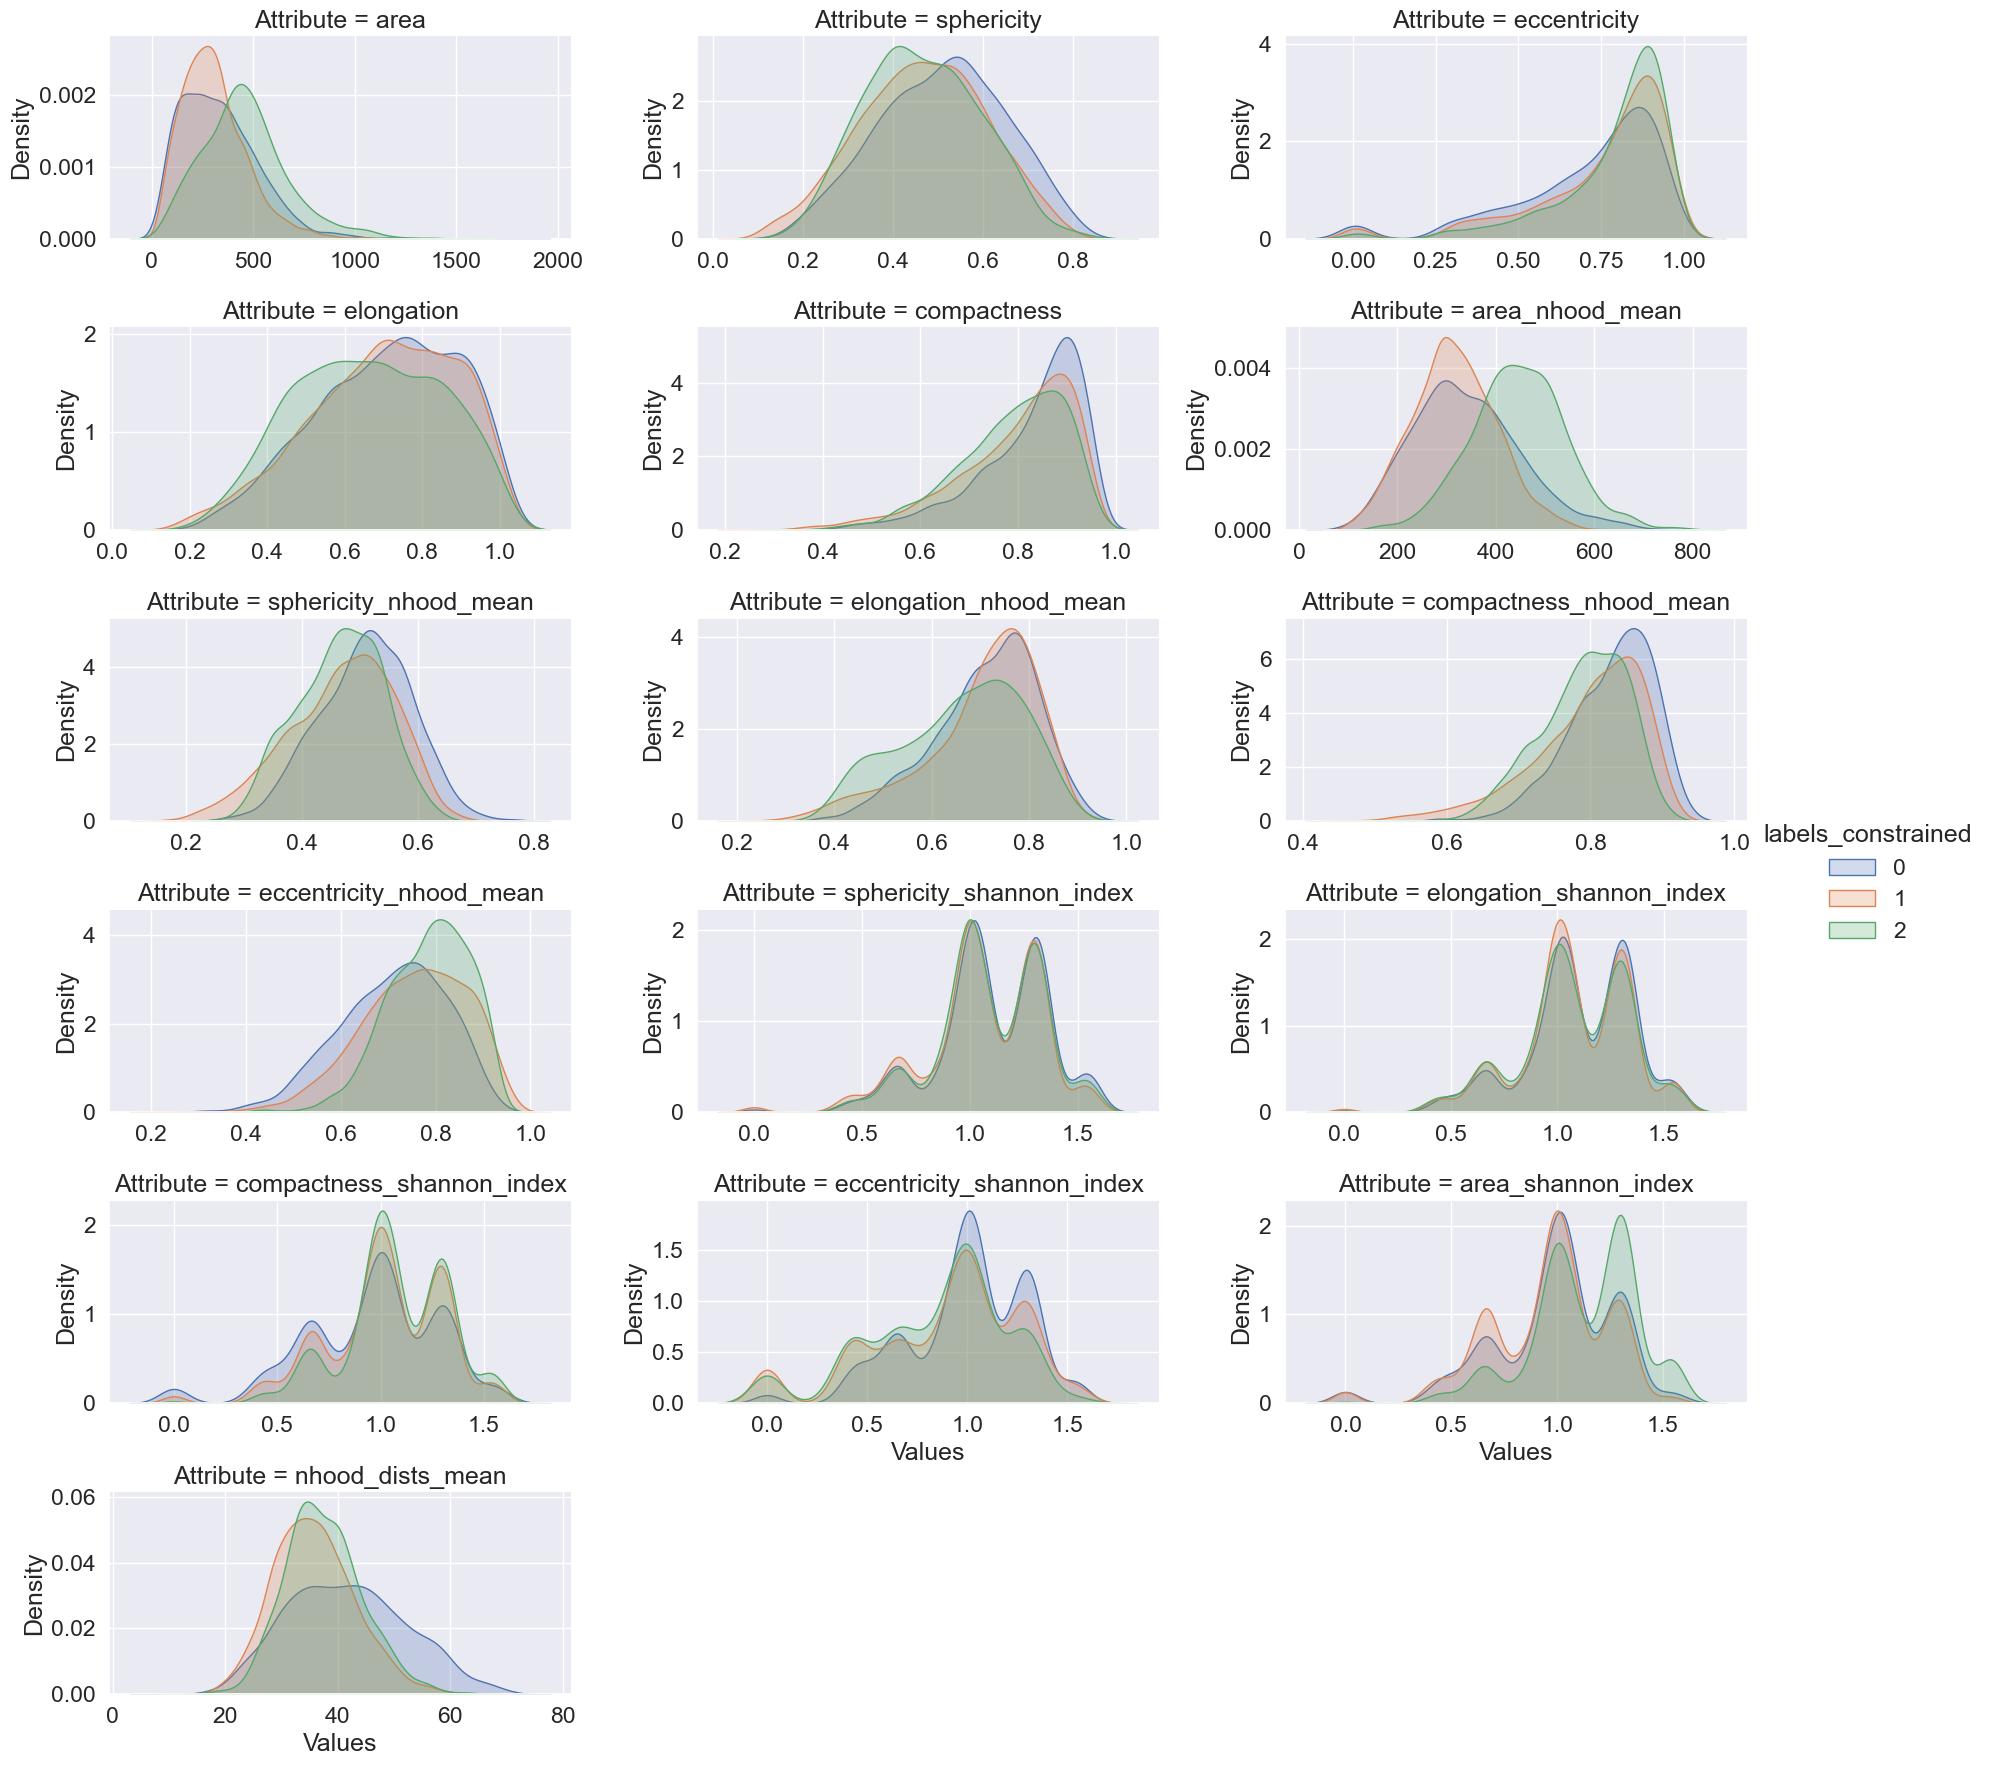

In [14]:
import seaborn as sns

# tidy up the data
tidy = neoplastic.set_index("labels_constrained")[clust_vars.columns]
tidy = tidy.stack()
tidy = tidy.reset_index()
tidy = tidy.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)

sns.set(font_scale=1.5)
facets = sns.FacetGrid(
    data=tidy,
    col="Attribute",
    hue="labels_constrained",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot from `sns.kdeplot`
facets.map(sns.kdeplot, "Values", shade=True).add_legend()

The clearest differences can be seen in the area and neighborhood mean distances since we wanted to epmhasize these features by not scaling them to the same scale as the other features.